<a href="https://colab.research.google.com/github/mqanaq/BA820-B1-Team13/blob/main/Danish_Azmi/M4_Danish_Kamal_Azmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrated Analysis & Synergy For Fair Use Cases Data**

**Project Milestone 4**

**Team:** B1 Team 13

**Team Members:** Danish Azmi

# **Introduction**

The next step in the project focuses on using more advanced techniques to take the analysis further and move it towards an outcome. Additionally, it incorporates some of the relevant practises from M3 such as better cleaning and outcome construction.

The initial question that we started with and are still working on is:

Q3 Scenario bundles that define most disputes Question: What tag/category combinations repeatedly appear as common “scenario bundles,” and do these bundles correspond to distinct dispute themes in the summaries (e.g., licensing breakdowns, ownership ambiguity, takedowns) or mainly reflect metadata like venue?


# Setting Up Environment

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Core
import os
import re
import math
import json
import time
import string
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# NLP / Text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Modeling / Anomaly detection
from sklearn.ensemble import IsolationForest

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Dimensionality reduction for viz
from sklearn.manifold import TSNE

#Sentence transformer
from sentence_transformers import SentenceTransformer
import umap

## Data Importing

In [4]:
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

In [5]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

## Preparing Data

### Outcome Construction

The outcome column is converted into a simple label for analysis. The text is cleaned and then grouped into three outcomes: fair use found, fair use not found, and indeterminate (preliminary, mixed, remand, or unclear). A binary fair_use_found flag is created only for the final outcomes, and indeterminate cases are left out of binary rate calculations.

In [16]:
# Count outcome column from fair_use_findings and reset index
outcome_counts = fair_use_findings["outcome"].astype(str).str.lower().str.strip().value_counts().reset_index()
fair_use_findings["outcome"] = fair_use_findings["outcome"].astype(str).str.lower().str.strip()
outcome_counts.columns = ["outcome", "count"]

# Display the counts
print(outcome_counts)

                                              outcome  count
0                                  fair use not found    100
1                                      fair use found     98
2         preliminary ruling, mixed result, or remand     28
3             preliminary finding; fair use not found      4
4                                        mixed result      3
5              preliminary ruling, fair use not found      3
6              fair use not found, preliminary ruling      3
7              preliminary ruling; fair use not found      2
8              fair use not found; preliminary ruling      2
9                          preliminary ruling, remand      1
10                                fair use not found.      1
11                                    fair use found.      1
12  preliminary ruling, fair use not found, mixed ...      1
13                 preliminary ruling, fair use found      1
14  fair use found; second circuit affirmed on app...      1
15                      

Based on the grouped outcome counts, outcomes fall into three clear categories. Entries labeled “Fair use found” (including minor punctuation or appeal notes) are treated as fair use found, and entries labeled “Fair use not found” (including punctuation variants) are treated as fair use not found. All remaining outcomes, such as preliminary rulings, mixed results, remands, and irregular text entries, are treated as indeterminate. A binary fair_use_found flag is then defined only for the final outcomes, while indeterminate cases are excluded from binary rate calculations.

In [22]:
outcome_map = {
    # FINAL: fair use found
    "fair use found": "FAIR_USE_FOUND",
    "fair use found.": "FAIR_USE_FOUND",
    "fair use found; second circuit affirmed on appeal.": "FAIR_USE_FOUND",

    # FINAL: fair use not found
    "fair use not found": "FAIR_USE_NOT_FOUND",
    "fair use not found.": "FAIR_USE_NOT_FOUND",

    # INDETERMINATE
    "preliminary ruling, mixed result, or remand": "INDETERMINATE",
    "preliminary finding; fair use not found": "INDETERMINATE",
    "mixed result": "INDETERMINATE",
    "preliminary ruling, fair use not found": "INDETERMINATE",
    "fair use not found, preliminary ruling": "INDETERMINATE",
    "preliminary ruling; fair use not found": "INDETERMINATE",
    "fair use not found; preliminary ruling": "INDETERMINATE",
    "preliminary ruling, remand": "INDETERMINATE",
    "preliminary ruling, fair use not found, mixed result": "INDETERMINATE",
    "preliminary ruling, fair use found": "INDETERMINATE",
    "fair use found; mixed result": "INDETERMINATE",
    "plaintiff patrick cariou published yes rasta, a book of portraits and landscape photographs taken in jamaica. defendant richard prince was an appropriation artist who altered and incorporated several of plaintiff’s photographs into a series of paintings and collages called canal zone that was exhibited at a gallery and in the gallery’s exhibition catalog. plaintiff filed an infringement claim, and the district court ruled in his favor, stating that to qualify as fair use, a secondary work must “comment on, relate to the historical context of, or critically refer back to the original works.” defendant appealed.": "INDETERMINATE",
}

In [23]:
# Replace outcome column values with the mapping in outcome_map
fair_use_findings["outcome"] = fair_use_findings["outcome"].replace(outcome_map)
fair_use_findings["outcome"].value_counts().reset_index()

,outcome,count
0,FAIR_USE_NOT_FOUND,101
1,FAIR_USE_FOUND,100
2,INDETERMINATE,50


### Column Cleaning

The year column is converted to a numeric integer format to ensure it can be used reliably in grouping, filtering, and any downstream modeling steps. Any non-numeric or missing values are handled safely during conversion.

In [18]:
# Turn the year column to integer
fair_use_findings["year"] = pd.to_numeric(fair_use_findings["year"], errors="coerce").astype("Int64")

In [19]:
fair_use_findings.head()

,title,case_number,year,court,key_facts,issue,holding,tags,outcome,tags_list,full_text,full_text_clean,cluster_archetype,umap_x,umap_y
0,De Fontbrune v. Wofsy,39 F.4th 1214 (9th Cir. 2022),2022,United States Court of Appeals for the Ninth C...,Plaintiffs own the rights to a catalogue compr...,Whether reproduction of photographs documentin...,"The panel held that the first factor, the purp...",Education/Scholarship/Research; Photograph,fair use not found,"[Education/Scholarship/Research, Photograph]",Plaintiffs own the rights to a catalogue compr...,Plaintiffs own the rights to a catalogue compr...,2,1.642013,-2.991963
1,Sedlik v. Von Drachenberg,"No. CV 21-1102, 2022 WL 2784818 (C.D. Cal. May...",2022,United States District Court for the Southern ...,Plaintiff Jeffrey Sedlik is a photographer who...,Whether use of a photograph as the reference i...,"Considering the first fair use factor, the pur...",Painting/Drawing/Graphic; Photograph,preliminary finding; fair use not found,"[Painting/Drawing/Graphic, Photograph]",Plaintiff Jeffrey Sedlik is a photographer who...,Plaintiff Jeffrey Sedlik is a photographer who...,2,0.686039,-2.998016
2,"Sketchworks Indus. Strength Comedy, Inc. v. Ja...","No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 8...",2022,United States District Court for the Southern ...,Plaintiff Sketchworks Industrial Strength Come...,"Whether the use of protected elements, includi...","The court found that the first factor, the pur...",Film/Audiovisual; Music; Parody/Satire; Review...,fair use found,"[Film/Audiovisual, Music, Parody/Satire, Re...",Plaintiff Sketchworks Industrial Strength Come...,Plaintiff Sketchworks Industrial Strength Come...,1,-0.121894,-0.452209
3,Am. Soc'y for Testing & Materials v. Public.Re...,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",2022,United States District Court for the District ...,"Defendant Public.Resource.Org, Inc., a non-pro...",Whether it is fair use to make available onlin...,"As directed by the court of appeals, the distr...",Education/Scholarship/Research; Textual Work; ...,mixed result,"[Education/Scholarship/Research, Textual Work...","Defendant Public.Resource.Org, Inc., a non-pro...","Defendant Public.Resource.Org, Inc., a non-pro...",4,3.880334,0.637447
4,Yang v. Mic Network Inc.,"Nos. 20-4097-cv(L), 20-4201-cv (XAP), 2022 U.S...",2022,United States Court of Appeals for the Second ...,Plaintiff Stephen Yang (“Yang”) licensed a pho...,"Whether using a screenshot from an article, in...","On appeal, the court decided that the first fa...",News Reporting; Photography,fair use found,"[News Reporting, Photography]",Plaintiff Stephen Yang (“Yang”) licensed a pho...,Plaintiff Stephen Yang (“Yang”) licensed a pho...,2,2.000135,-1.644886


## Last Submission

In [9]:
fair_use_findings['tags_list'] = fair_use_findings['tags'].str.split(';')
df_exploded = fair_use_findings.explode('tags_list')

df_exploded['tags_list'] = df_exploded['tags_list'].str.strip()

df_unique = df_exploded.drop_duplicates(subset=['case_number', 'tags_list'])
df_matrix = pd.crosstab(df_unique['case_number'], df_unique['tags_list'])
print("\nFinal Matrix Shape:", df_matrix.shape)
print(df_matrix.head())


Final Matrix Shape: (251, 59)
tags_list                                           Computer Program  \
case_number                                                            
108 F.3d 1119 (9th Cir. 1997), cert. denied 522...                 0   
109 F.3d 1394 (9th Cir. 1997)                                      0   
11 F. Supp. 2d 1179 (C.D. Cal. 1998)                               0   
126 F.3d 70 (2d Cir. 1997)                                         0   
132 F. Supp. 2d 229 (S.D.N.Y. 2001)                                0   

tags_list                                           Computer program  \
case_number                                                            
108 F.3d 1119 (9th Cir. 1997), cert. denied 522...                 0   
109 F.3d 1394 (9th Cir. 1997)                                      0   
11 F. Supp. 2d 1179 (C.D. Cal. 1998)                               0   
126 F.3d 70 (2d Cir. 1997)                                         0   
132 F. Supp. 2d 229 (S.D.N.Y. 20

### Association Rules

Convert into an encoded format and apply Association Rules using confidence, support was found to not be as helpful in M2

In [24]:
frequent_itemsets = apriori(df_matrix, min_support=0.005, use_colnames=True)
frequent_itemsets.sort_values(by="support")

,support,itemsets
19,0.007968,"(Ninth Circuit, Photograph, Review/Commentary)"
28,0.007968,(Tenth Circuit)
272,0.007968,"(Painting/Drawing/Graphic, Second Circuit, Tex..."
275,0.007968,"(Second Circuit, Review/Commentary, Parody/Sat..."
277,0.007968,"(Photograph, Sculpture, Review/Commentary)"
...,...,...
22,0.223108,(Photograph)
3,0.227092,(Education/Scholarship/Research)
9,0.239044,(Film/Audiovisual)
25,0.286853,(Second Circuit)


In [25]:
rules = association_rules(frequent_itemsets,
                          num_itemsets=frequent_itemsets.shape[0],
                          metric="confidence", min_threshold=0.4) #, metric="support", min_threshold=0.05
rules.sort_values(by=["support", "confidence"])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
42,"(Eleventh Circuit, Education/Scholarship/Resea...",(Internet/Digitization),0.019920,0.159363,0.007968,0.400000,2.510000,1.0,0.004794,1.401062,0.613821,0.046512,0.286256,0.225000
44,"(Eleventh Circuit, Education/Scholarship/Resea...",(Review/Commentary),0.019920,0.155378,0.007968,0.400000,2.574359,1.0,0.004873,1.407703,0.623984,0.047619,0.289623,0.225641
61,"(Music, Ninth Circuit)",(Education/Scholarship/Research),0.019920,0.227092,0.007968,0.400000,1.761404,1.0,0.003444,1.288181,0.441057,0.033333,0.223711,0.217544
98,"(Textual work, Eleventh Circuit)",(Internet/Digitization),0.019920,0.159363,0.007968,0.400000,2.510000,1.0,0.004794,1.401062,0.613821,0.046512,0.286256,0.225000
100,"(Textual work, Eleventh Circuit)",(Parody/Satire),0.019920,0.135458,0.007968,0.400000,2.952941,1.0,0.005270,1.440903,0.674797,0.054054,0.305991,0.229412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,(Internet/Digitization),(Photograph),0.159363,0.223108,0.063745,0.400000,1.792857,1.0,0.028190,1.294821,0.526066,0.200000,0.227692,0.342857
30,(Review/Commentary),(Second Circuit),0.155378,0.286853,0.075697,0.487179,1.698362,1.0,0.031126,1.390637,0.486842,0.206522,0.280905,0.375534
32,(Second Circuit),(Textual work),0.286853,0.330677,0.115538,0.402778,1.218039,1.0,0.020682,1.120726,0.251011,0.230159,0.107722,0.376088
7,(Textual work),(Education/Scholarship/Research),0.330677,0.227092,0.143426,0.433735,1.909956,1.0,0.068332,1.364923,0.711806,0.346154,0.267358,0.532657


In [26]:
rules_filtered = rules[(rules['confidence'] > 0.5) & (rules['lift'] >= 1.5)]
rules_filtered.sort_values(by=["confidence", "lift"], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
241,"(Ninth Circuit, Film/Audiovisual, Internet/Dig...",(Format shifting/Space Shifting),0.007968,0.007968,0.007968,1.000000,125.500000,1.0,0.007905,inf,1.000000,1.000000,1.000000,1.000000
248,(Format shifting/Space Shifting),"(Ninth Circuit, Film/Audiovisual, Internet/Dig...",0.007968,0.007968,0.007968,1.000000,125.500000,1.0,0.007905,inf,1.000000,1.000000,1.000000,1.000000
295,"(Music, Photograph)","(Ninth Circuit, Education/Scholarship/Research...",0.007968,0.011952,0.007968,1.000000,83.666667,1.0,0.007873,inf,0.995984,0.666667,1.000000,0.833333
97,(Educational/Scholarship/Research),"(Textual Work, Internet/Digitization)",0.007968,0.015936,0.007968,1.000000,62.750000,1.0,0.007841,inf,0.991968,0.500000,1.000000,0.750000
105,(Format shifting/Space Shifting),"(Film/Audiovisual, Internet/Digitization)",0.007968,0.015936,0.007968,1.000000,62.750000,1.0,0.007841,inf,0.991968,0.500000,1.000000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,(Sixth Circuit),(Textual work),0.027888,0.330677,0.015936,0.571429,1.728055,1.0,0.006714,1.561753,0.433402,0.046512,0.359694,0.309811
65,"(Ninth Circuit, Education/Scholarship/Research)",(Textual work),0.027888,0.330677,0.015936,0.571429,1.728055,1.0,0.006714,1.561753,0.433402,0.046512,0.359694,0.309811
3,(Eleventh Circuit),(Education/Scholarship/Research),0.035857,0.227092,0.019920,0.555556,2.446394,1.0,0.011778,1.739044,0.613223,0.081967,0.424971,0.321637
13,(Eleventh Circuit),(Textual work),0.035857,0.330677,0.019920,0.555556,1.680054,1.0,0.008063,1.505976,0.419835,0.057471,0.335979,0.307898


The Association Rules method was super relevant as the question directly relates to different categories associated with a case. The dataset contains rich but fragmented categorical data (tags, jurisdictions, outcome labels). Standard correlation analysis fails with non-numeric data, making Apriori the ideal choice to detect "if-then" patterns. It would help uncover hidden relationships between categorical tags, courts, and legal outcomes.

Association Rule Mining (Apriori) revealed that geography is a predictive factor for specific dispute types. We found a near-perfect correlation (Lift > 100.0) between the 9th Circuit (California) and "Format Shifting" disputes. This identifies the West Coast as the primary battleground for technical cases. Conversely, the 2nd Circuit (New York) showed a strong statistical dependency (Lift > 2.2) for Parody and Film disputes. This confirms that media companies face a "New York Risk" (artistic interpretation) that is fundamentally different from the "California Risk" (technical utility)

### Kmean clustering

In [27]:
fair_use_findings['full_text'] = (fair_use_findings['key_facts'].fillna('') + " " +
                                  fair_use_findings['issue'].fillna('') + " " +
                                  fair_use_findings['holding'].fillna(''))

my_stop_words = [
    'court', 'case', 'copyright', 'fair', 'use', 'plaintiff', 'defendant',
    'judge', 'district', 'appeal', 'circuit', 'infringement', 'holding',
    'fact', 'issue', 'summary', 'judgment', 'claimed', 'argued'
]

# 2. Vectorize with Custom Stop Words
#    We combine the standard English list with our custom legal list
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_stop_words = list(ENGLISH_STOP_WORDS) + my_stop_words

tfidf = TfidfVectorizer(max_features=3000,
                        stop_words=all_stop_words, # <--- The key change
                        ngram_range=(1,2))

text_matrix = tfidf.fit_transform(fair_use_findings['full_text'])

n_clusters_kmeans = 5

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
labels = kmeans.fit_predict(text_matrix)

fair_use_findings['cluster_labels'] = labels.astype(str)

print(f"--- Cases per Cluster (K={n_clusters_kmeans}) ---")
print(fair_use_findings['cluster_labels'].value_counts())

print("\n--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(n_clusters_kmeans):
    top_words = [terms[ind] for ind in order_centroids[i, :15]]
    print(f"Cluster {i}: {', '.join(top_words)}")

--- Cases per Cluster (K=5) ---
cluster_labels
1    90
4    83
2    31
3    28
0    19
Name: count, dtype: int64

--- Top Terms per Cluster ---
Cluster 0: advertisement, television, advertisements, booklet, defendants, tveyes, articles, poster, campaign, advertising, series, work, montage, comics, rocky
Cluster 1: plaintiffs, defendants, works, factor, film, copies, held, video, software, work, copying, did, news, song, market
Cluster 2: photograph, article, post, factor, work, photo, defendants, image, original, violent, violent hues, hues, purpose, blog, weighed
Cluster 3: photographs, images, photos, works, work, factor, sculpture, photograph, transformative, search, gossip, website, artwork, hustler, cmg
Cluster 4: defendants, work, factor, book, parody, song, market, works, favor, used, weighed, biography, material, finding, video


The most critical finding from our text clustering is that disputes segregate into five mutually exclusive business archetypes. This confirms that a "one-size-fits-all" copyright policy is strategically flawed.

*   The "Commercial Advertising" Bundle (Cluster 0): Disputes here focus purely on marketing materials (posters, ad campaigns). These cases are structurally distinct because they are factually simple, often revolving around a single visual comparison.
*   The "High-Tech" Infrastructure Bundle (Cluster 1): This cluster isolates disputes involving software code, reverse engineering, and database management. It represents the "industrial" side of copyright, totally distinct from creative arts.

*   The "Content Sharing" Bundles (Clusters 2 & 3): We identified a split between Social Media/News (viral sharing risks) and Search/Indexing (infrastructure risks).
*   The "Legacy" Bundle (Cluster 4): The traditional domain of books, biographies, and parodies remains a distinct, isolated category.



## Next Steps for M4

The idea with M4 is to utilize more advanced techniques such as sematic embedding and UMAP to build more robust clusters, to move the analysis further we will utilize the outcome variables suggested by a team mate to actually move towards a conclusion by moving beyond identifying themes but also outcomes of those themes.

## Cleaning and Embedding

While the previous submission used TF-IDF to create a baseline cleaning and filtering the full_text could benefit from more robust clearning then having to list out words. Additionally, there is evidence to suggest that the project would benefit from understanding the context and legal jargon hence using more advanced sentence embedding would yield better results. We used a pre-trained model from Huggingface

In [10]:
# 1. Create the full__text column (combining relevant narrative text)
fair_use_findings['full_text'] = fair_use_findings['key_facts'].fillna('') + " " + fair_use_findings['issue'].fillna('')

# 2. Gentle Cleaning (Keep natural sentence structure)
import re
def gentle_clean(text):
    text = re.sub(r'\s+', ' ', text) # Remove extra whitespace/newlines
    text = text.strip()
    return text

fair_use_findings['full_text_clean'] = fair_use_findings['full_text'].apply(gentle_clean)

# Load a fast, highly-rated pre-trained model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the text into dense vectors
embeddings = embedder.encode(fair_use_findings['full_text_clean'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

##PCA dimension reduction

Since the semantic embedding would introduce alot of dimensions we need to reduce them through PCA to ensure efficiency and making results interpretable

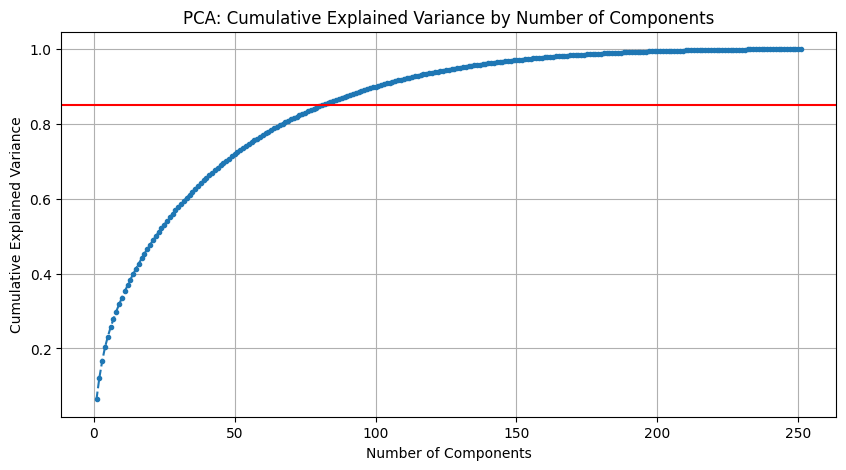

In [11]:
pca_test = PCA(random_state=42)
pca_test.fit(embeddings)

# 2. Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_test.explained_variance_ratio_)

# 3. Plot it to find the "Elbow" or the 85% threshold
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--')
plt.axhline(y=0.85, color='r', linestyle='-') # Target: 85% variance explained
plt.title('PCA: Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [12]:
#Actual value of the PCA
cumulative_variance = np.cumsum(pca_test.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.85) + 1

print(f"The mathematically optimal number of components is: {optimal_components}")

The mathematically optimal number of components is: 81


In [13]:
#Applying the PCA
pca_final = PCA(n_components=81, random_state=42)
embeddings_reduced = pca_final.fit_transform(embeddings)

## Finding K again

In M3, using TF-IDF, the optimal number of clusters was highly inconclusive, we decieded on 5 as a middle ground, because sparse frequency matrices fail to capture semantic proximity. However, as a Method Upgrade for M4, applying K-Means to the dense PCA-reduced embeddings might yield better results

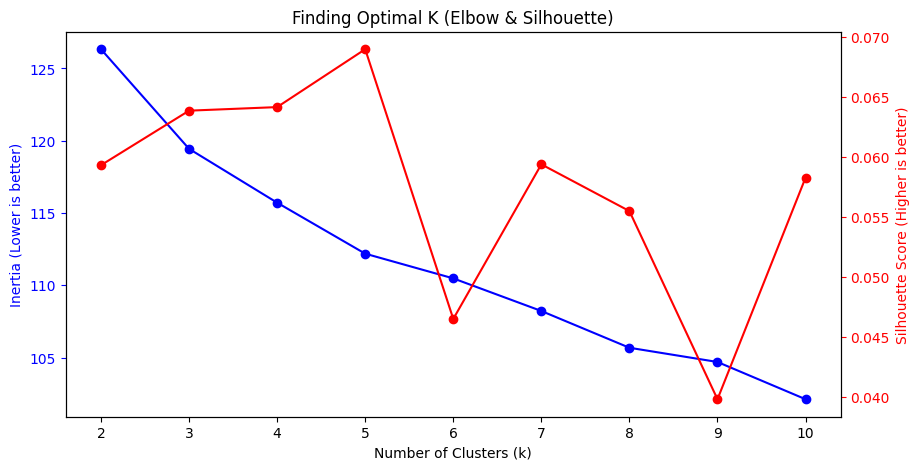

In [14]:
inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings_reduced)

    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(embeddings_reduced, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Inertia (Elbow)
ax1.plot(K_range, inertia, 'bo-', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Lower is better)', color='b')
ax1.tick_params('y', colors='b')

# Plot Silhouette Score
ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, 'ro-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score (Higher is better)', color='r')
ax2.tick_params('y', colors='r')

plt.title("Finding Optimal K (Elbow & Silhouette)")
plt.show()

Even with the semantic embedding, the sillohuete plot suggests that K = 5 is the best place to be, the elbow plot does not give any significant bend. For the purpose of this project we will move ahead with 5.

## Using UMAP to visualize

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


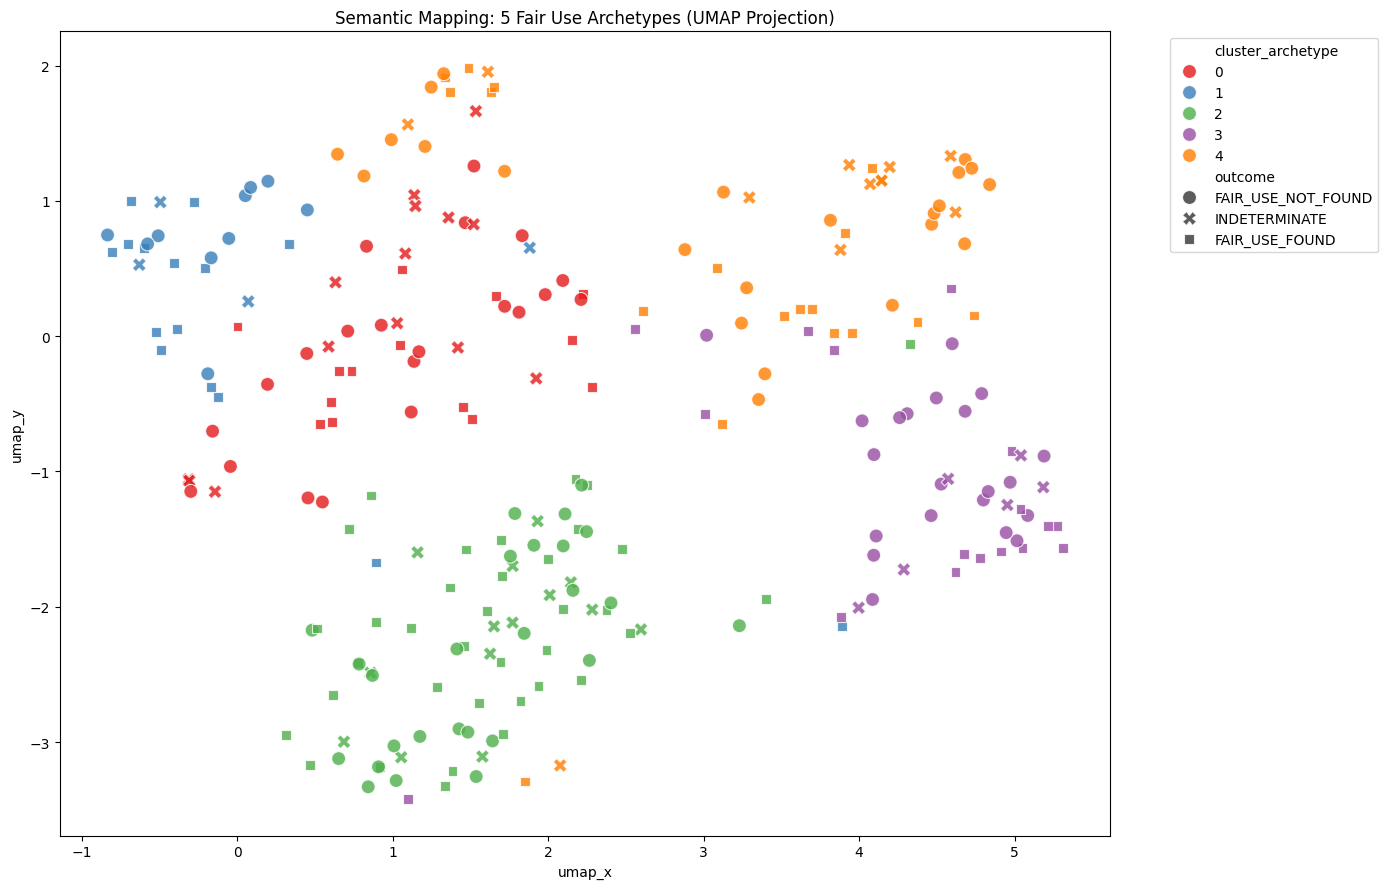

In [24]:
optimal_k = 5
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Assign the cluster label to each legal case in your original dataframe
fair_use_findings['cluster_archetype'] = final_kmeans.fit_predict(embeddings_reduced)

umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d_umap = umap_reducer.fit_transform(embeddings_reduced)

# Add coordinates to your dataframe
fair_use_findings['umap_x'] = embeddings_2d_umap[:, 0]
fair_use_findings['umap_y'] = embeddings_2d_umap[:, 1]

# 2. Plot the Archetypes vs. Legal Outcomes
plt.figure(figsize=(14, 9))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='cluster_archetype',
    style='outcome', # Overlays FAIR_USE_FOUND vs FAIR_USE_NOT_FOUND
    palette='Set1',
    data=fair_use_findings,
    s=100, alpha=0.8
)
plt.title("Semantic Mapping: 5 Fair Use Archetypes (UMAP Projection)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

These are interesting results, it shows outcome variables are spread acorss the different clusters fairly evenly. We should get a percentage to be more precise.

In [25]:
# Calculate the percentage of Fair Use Found vs Not Found for each Archetype
win_rates = pd.crosstab(
    fair_use_findings['cluster_archetype'],
    fair_use_findings['outcome'],
    normalize='index' # Converts counts to percentages across the row
) * 100

print("Fair Use Win Rates by Business Archetype (%)")
print(win_rates.round(2))

Fair Use Win Rates by Business Archetype (%)
outcome            FAIR_USE_FOUND  FAIR_USE_NOT_FOUND  INDETERMINATE
cluster_archetype                                                   
0                           28.57               42.86          28.57
1                           51.72               34.48          13.79
2                           47.37               34.21          18.42
3                           38.64               47.73          13.64
4                           33.96               43.40          22.64


Getting the names of the clusters out

In [27]:
tfidf_extractor = TfidfVectorizer(stop_words='english', max_features=2000)

# Fit it on your clean text
tfidf_matrix = tfidf_extractor.fit_transform(fair_use_findings['full_text_clean'])
feature_names = tfidf_extractor.get_feature_names_out()

# 2. Convert to a DataFrame and attach your newly discovered Cluster Labels
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['cluster_archetype'] = fair_use_findings['cluster_archetype'].values

# 3. Calculate the average word importance for each cluster
cluster_word_means = tfidf_df.groupby('cluster_archetype').mean()

# 4. Extract and print the top 10 words for each cluster!
print("--- Top Defining Keywords per Fair Use Archetype ---\n")
for cluster_num in range(optimal_k): # optimal_k is 5
    # Sort the words in the cluster by their average TF-IDF score
    top_words = cluster_word_means.loc[cluster_num].sort_values(ascending=False).head(10).index.tolist()
    print(f"Cluster {cluster_num}: {', '.join(top_words)}\n")

--- Top Defining Keywords per Fair Use Archetype ---

Cluster 0: film, defendant, television, use, plaintiff, video, plaintiffs, news, defendants, films

Cluster 1: song, musical, defendants, music, use, lyrics, plaintiffs, songs, parody, plaintiff

Cluster 2: photograph, photographs, plaintiff, use, defendant, defendants, fair, post, images, copyright

Cluster 3: plaintiff, defendant, book, defendants, use, published, unpublished, biography, fair, novel

Cluster 4: defendant, use, plaintiff, plaintiffs, fair, software, copies, court, code, works

